In [1]:
import os
MODEL_NAME = "my_model"
DATA_DIR = os.path.join(os.getcwd(), r'TensorFlow\workspace\training')
MODELS_DIR = os.path.join(DATA_DIR, 'exported-models')
PATH_TO_CFG = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'pipeline.config'))
PATH_TO_CKPT = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, 'checkpoint/'))
LABEL_FILENAME = 'label_map.pbtxt'
PATH_TO_LABELS = os.path.join(MODELS_DIR, os.path.join(MODEL_NAME, LABEL_FILENAME))

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'    # Suppress TensorFlow logging
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

tf.get_logger().setLevel('ERROR')           # Suppress TensorFlow logging (2)

# Enable GPU dynamic memory allocation
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(PATH_TO_CFG)
model_config = configs['model']
detection_model = model_builder.build(model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(PATH_TO_CKPT, 'ckpt-0')).expect_partial()

@tf.function
def detect_fn(image):
    """Detect objects in image."""

    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

In [3]:

category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS,
                                                                    use_display_name=True)

### Webcam Detection

In [4]:
import cv2

cap = cv2.VideoCapture(0)

In [5]:
import numpy as np

while True:
    # Read frame from camera
    ret, image_np = cap.read()

    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)

    # Things to try:
    # Flip horizontally
    # image_np = np.fliplr(image_np).copy()

    # Convert image to grayscale
    # image_np = np.tile(
    #     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections, predictions_dict, shapes = detect_fn(input_tensor)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
          image_np_with_detections,
          detections['detection_boxes'][0].numpy(),
          (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
          detections['detection_scores'][0].numpy(),
          category_index,
          use_normalized_coordinates=True,
          max_boxes_to_draw=200,
          min_score_thresh=.30,
          agnostic_mode=False)

    # Display output
    cv2.imshow('object detection', cv2.resize(image_np_with_detections, (800, 600)))

    if cv2.waitKey(25) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

### Images Detection

In [4]:
IMAGE_PATHS = os.path.join(DATA_DIR, 'test-images')

In [5]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

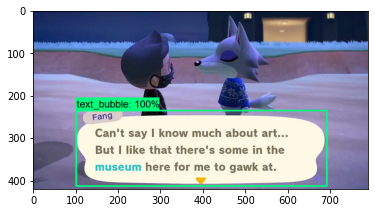

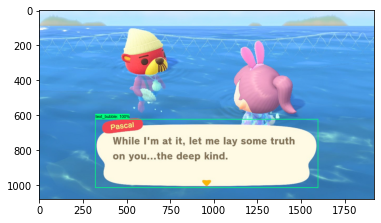

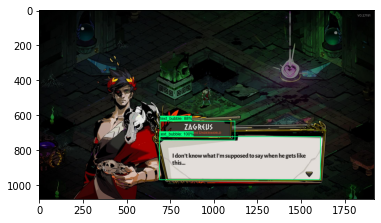

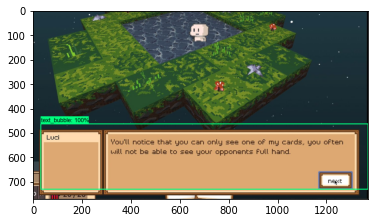

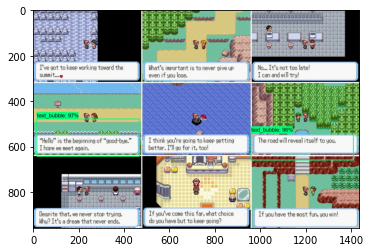

In [6]:
IMAGE_PATH = os.path.join(DATA_DIR, 'test-images')

for image_path in os.listdir(IMAGE_PATH):
    img = cv2.imread(os.path.join(IMAGE_PATH, image_path))
    image_np = np.array(img)
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)

    num_detections = int(detections[0].pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                for key, value in detections[0].items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
    plt.show()

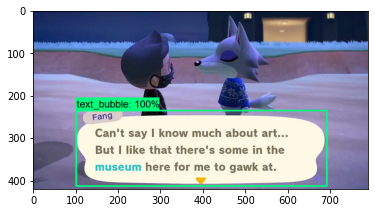

In [7]:
IMAGE_PATH = os.path.join(DATA_DIR, 'test-images', 'test_1.jpg')

img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections[0].pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections[0].items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.8,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()